<a href="https://colab.research.google.com/github/sgr1118/GD-NLP/blob/main/%5BExp_08%5D_Movie_review_Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

In [ ]:
# 영구적인 라이브러리 설치하기위한 경로 지정
import os, sys

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/MyDrive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# konlpy, Mecab 형태소 분석기 설치 스크립트 실행
# colab에 영구적으로 설치를 하고싶었으나 작동에 오류가 생겨 향후 다시 해보기로 결정
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
# gensim 라이브러리 업데이트 
# LMS와 일치하게 버젼을 4.1.2로 맞춘다
# 경로를 설정하여 영구적으로 해당 버젼을 사용할 수 있게 환경을 조성하였다.
!pip install --target=$my_path gensim==4.1.2

In [ ]:
# 파이브러리 버젼 확인
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.5
0.6.0
4.2.0


In [ ]:
# 1. 데이터 불러오기
import pandas as pd
import konlpy
import gensim
train_data = pd.read_table('/content/drive/MyDrive/Aiffel/EX/EX8_txt/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Aiffel/EX/EX8_txt/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
# 2. 데이터로더 구성
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
# 불용어 리스트
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
  train_data.drop_duplicates(subset=['document'], inplace=True)
  train_data = train_data.dropna(how = 'any') 
  test_data.drop_duplicates(subset=['document'], inplace=True)
  test_data = test_data.dropna(how = 'any')

  X_train = [] # X_train의 빈 리스트 생성
  for sentence in train_data['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

  X_test = [] # X_test의 빈 리스트 생성
  for sentence in test_data['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

  words = np.concatenate(X_train).tolist() # .tolist() : array를 list로 변경
  counter = Counter(words)                 # collection 모듈의 Counter 클래스로 데이터의 개수 확인
  counter = counter.most_common(10000-4)   # most_common() : 데이터의 개수가 많은 순으로 정렬된 배열 리턴
  vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] # LMS 과정과 다르게 함수에서 미리 사전에 정의해둔다.
  word_to_index = {word:index for index, word in enumerate(vocab)}

  def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    # wordlist에 있는 word에 대해서 만약에 word가 word_to_index에 존재하면 인덱스 값을, 존재하지 않으면 <UNK>를 인덱스로 반환함
        
  X_train = list(map(wordlist_to_indexlist, X_train))
  X_test = list(map(wordlist_to_indexlist, X_test))
        
  return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
  
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print('훈련 샘플 개수: {}, 테스트 개수: {}'.format(len(X_train), len(X_test)))
print('훈련 샘플 개수: {}, 테스트 개수: {}'.format(len(y_train), len(y_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157
훈련 샘플 개수: 146182, 테스트 개수: 49157


In [ ]:
# 텍스트 확인
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[0])
print(word_to_index['<PAD>'])

<PAD>
0


In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
  return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
  return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
  return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
  return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
# 3. 모델 구성을 위한 데이터 분석 및 가공
total_data_text = list(X_train) + list(X_test)
# txt데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

# 적절한 최대 문장 길이는 41이다.

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩다. 


In [ ]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [ ]:
# pad_sequences 을 활용한 패딩 추가
# padding은 pre로 설정을 해보았다. 이유는 RNN이 학습을 할 때 순차적으로 데이터가 입력이된다.
# 마지막 입력이 무의미한 값으로 입력되는 post보다 pre가 더 좋은 성능을 낼 것으로 생각한다.
import tensorflow as tf
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape, X_test.shape)

(146182, 41) (49157, 41)


In [ ]:
# 4. 모델 구상 - 1 (RNN)
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수이며 직접 구성한 임베딩이기에 차원 수는 임의로 선택이 가능하다

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [ ]:
# 5. 모델 훈련 개시 - 1 (RNN)
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20 # 계속 바꿔보자

history1 = model1.fit(partial_x_train, 
                    partial_y_train,
                    epochs = epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 11s 31ms/step - loss: 0.1602 - accuracy: 0.9399 - val_loss: 0.4893 - val_accuracy: 0.8469
Epoch 2/20
266/266 [==============================] - 8s 29ms/step - loss: 0.1520 - accuracy: 0.9434 - val_loss: 0.5207 - val_accuracy: 0.8443
Epoch 3/20
266/266 [==============================] - 8s 28ms/step - loss: 0.1477 - accuracy: 0.9454 - val_loss: 0.5317 - val_accuracy: 0.8398
Epoch 4/20
266/266 [==============================] - 8s 28ms/step - loss: 0.1453 - accuracy: 0.9466 - val_loss: 0.5325 - val_accuracy: 0.8430
Epoch 5/20
266/266 [==============================] - 8s 29ms/step - loss: 0.1407 - accuracy: 0.9486 - val_loss: 0.5505 - val_accuracy: 0.8437
Epoch 6/20
266/266 [==============================] - 8s 28ms/step - loss: 0.1355 - accuracy: 0.9510 - val_loss: 0.5757 - val_accuracy: 0.8415
Epoch 7/20
266/266 [==============================] - 8s 29ms/step - loss: 0.1326 - accuracy: 0.9520 - val_loss: 0.5759 - val_accuracy: 0.841

In [ ]:
history_dict1 = history1.history
print(history_dict1.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


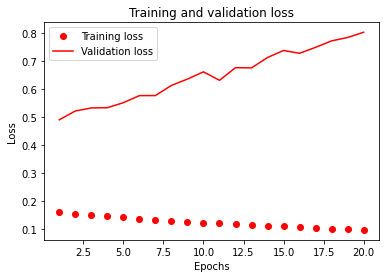

In [ ]:
# 6. Loss, Accuracy 그래프 시각화 - 1 (RNN)
import matplotlib.pyplot as plt

acc = history_dict1['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

# "ro"는 "빨간색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# r는 "빨간 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

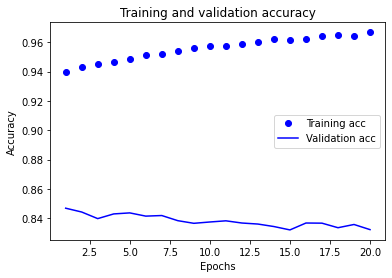

In [ ]:
plt.clf()   # 그림을 초기화합니다
# "bo"는 "파란색 점"입니다
plt.plot(epochs, acc, 'bo', label='Training acc')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# 학습이 끝난 모델을 테스트셋으로 평가
results1 = model1.evaluate(X_test, y_test, verbose=2)
print(results1)

# 학습 데이터와 검증 데이터의 학습률이 초기 에포크부터 상당히 높게 나왔다. 에포크를 20까지 설정할 필요는 없을 것으로 보인다.
# 다만 loss 그래프에서 학습 데이터와 검증 데이터의 loss는 다른 방향으로 움직이고있다. 검증용 loss가 꾸준히 올라가고 있다
# Validation loss가 하락하다가 다시 상승하는 구간은 모델이 과적합되고 있다고한다.
# 이 그래프에서는 초기부터 Validation loss가 하락하는 구간이 보이지않는다. 모델이 과적합 상태인지 의혹이 드는 부분이다.

1537/1537 - 5s - loss: 0.8092 - accuracy: 0.8312 - 5s/epoch - 3ms/step
[0.8091984987258911, 0.8311735987663269]


In [ ]:
# 4. 모델 구상 - 2 (GlobalMaxPooling1D)

vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

In [ ]:
# 5. 모델 훈련 개시 - 2 (GlobalMaxPooling1D)

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20 # 계속 바꿔보자

history2 = model2.fit(partial_x_train, 
                    partial_y_train,
                    epochs = epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 2s 6ms/step - loss: 0.1505 - accuracy: 0.9472 - val_loss: 0.5148 - val_accuracy: 0.8255
Epoch 2/20
266/266 [==============================] - 1s 4ms/step - loss: 0.1459 - accuracy: 0.9488 - val_loss: 0.5288 - val_accuracy: 0.8247
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1418 - accuracy: 0.9512 - val_loss: 0.5433 - val_accuracy: 0.8232
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1386 - accuracy: 0.9520 - val_loss: 0.5476 - val_accuracy: 0.8223
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1352 - accuracy: 0.9541 - val_loss: 0.5641 - val_accuracy: 0.8234
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1324 - accuracy: 0.9556 - val_loss: 0.5718 - val_accuracy: 0.8218
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1300 - accuracy: 0.9563 - val_loss: 0.5832 - val_accuracy: 0.8227
Epoch 

In [ ]:
history_dict2 = history2.history
print(history_dict2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


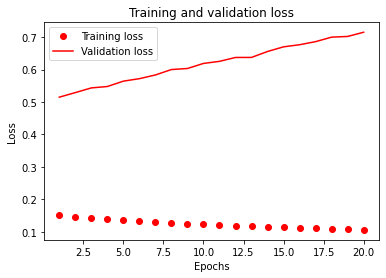

In [ ]:
# 6. Loss, Accuracy 그래프 시각화 - 2 (GlobalMaxPooling1D)
import matplotlib.pyplot as plt

acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "ro"는 "빨간색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# r는 "빨간 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

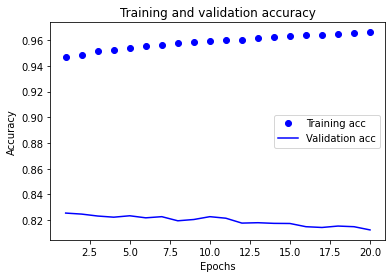

In [ ]:
plt.clf()   # 그림을 초기화합니다
# "bo"는 "파란색 점"입니다
plt.plot(epochs, acc, 'bo', label='Training acc')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# 학습이 끝난 모델을 테스트셋으로 평가
results2 = model2.evaluate(X_test, y_test, verbose=2)
print(results2)

# 학습 데이터와 검증 데이터의 학습률이 초기 에포크부터 상당히 높게 나왔다. 에포크를 20까지 설정할 필요는 없을 것으로 보인다.
# 다만 loss 그래프에서 학습 데이터와 검증 데이터의 loss는 다른 방향으로 움직이고있다. 검증용 loss가 꾸준히 올라가고 있다
# Validation loss가 하락하다가 다시 상승하는 구간은 모델이 과적합되고 있다고한다.
# 이 그래프에서는 초기부터 Validation loss가 하락하는 구간이 보이지않는다. 모델이 과적합 상태인지 의혹이 드는 부분이다.

1537/1537 - 2s - loss: 0.7214 - accuracy: 0.8144 - 2s/epoch - 1ms/step
[0.7214144468307495, 0.8143702745437622]


In [ ]:
# 4. 모델 구상 - 3 (1-D Convolution Neural Network(1-D CNN)모델)

vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(tf.keras.layers.MaxPooling1D(5))
model3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          1808      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                

In [ ]:
# 5. 모델 훈련 개시 - 3 (1-D Convolution Neural Network(1-D CNN)모델)

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20 # 계속 바꿔보자

history3 = model3.fit(partial_x_train, 
                    partial_y_train,
                    epochs = epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 4s 11ms/step - loss: 0.4700 - accuracy: 0.7742 - val_loss: 0.3476 - val_accuracy: 0.8491
Epoch 2/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3255 - accuracy: 0.8616 - val_loss: 0.3335 - val_accuracy: 0.8552
Epoch 3/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2910 - accuracy: 0.8783 - val_loss: 0.3308 - val_accuracy: 0.8561
Epoch 4/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2604 - accuracy: 0.8940 - val_loss: 0.3341 - val_accuracy: 0.8531
Epoch 5/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2290 - accuracy: 0.9103 - val_loss: 0.3492 - val_accuracy: 0.8538
Epoch 6/20
266/266 [==============================] - 3s 10ms/step - loss: 0.1968 - accuracy: 0.9261 - val_loss: 0.3743 - val_accuracy: 0.8537
Epoch 7/20
266/266 [==============================] - 2s 9ms/step - loss: 0.1656 - accuracy: 0.9403 - val_loss: 0.4132 - val_accuracy: 0.8484


In [ ]:
history_dict3 = history3.history
print(history_dict3.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


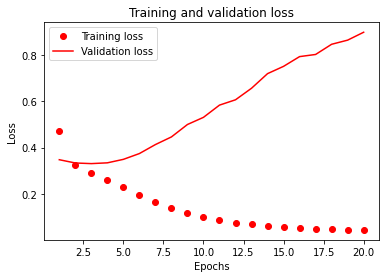

In [ ]:
# 6. Loss, Accuracy 그래프 시각화 - 3 (1-D Convolution Neural Network(1-D CNN)모델)

import matplotlib.pyplot as plt

acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# "ro"는 "빨간색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# r는 "빨간 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

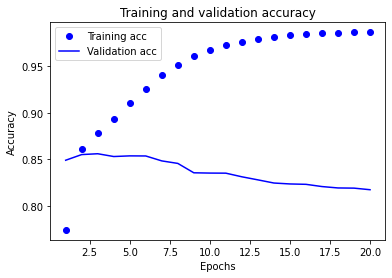

In [ ]:
plt.clf()   # 그림을 초기화합니다
# "bo"는 "파란색 점"입니다
plt.plot(epochs, acc, 'bo', label='Training acc')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# 학습이 끝난 모델을 테스트셋으로 평가 (1-D Convolution Neural Network(1-D CNN)모델)
results3 = model3.evaluate(X_test, y_test, verbose=2)
print(results3)

# 학습 데이터의 정확도는 지속적으로 상승했으나 검증용 데이터의 학습률은 미세하게 낮아지고있다.
# loss 그래프에서 에포크 5에서부터 Validation loss가 증가하는 것을 볼 수 있다. 이 부분부터 모델이 과적합을 일으킨다.

1537/1537 - 2s - loss: 0.9121 - accuracy: 0.8163 - 2s/epoch - 1ms/step
[0.9121440649032593, 0.8163232207298279]


In [ ]:
# 3가지 모델의 evaluate

# RNN 
# 1537/1537 - 5s - loss: 0.8092 - accuracy: 0.8312 - 5s/epoch - 3ms/step
# [0.8091984987258911, 0.8311735987663269]

# GlobalMaxPooling1D
# 1537/1537 - 2s - loss: 0.7214 - accuracy: 0.8144 - 2s/epoch - 1ms/step
# [0.7214144468307495, 0.8143702745437622]

# 1-D Convolution Neural Network(1-D CNN)
# 1537/1537 - 2s - loss: 0.9121 - accuracy: 0.8163 - 2s/epoch - 1ms/step
# [0.9121440649032593, 0.8163232207298279]

In [ ]:
# 7. 학습된 Embedding 레이어 분석
# model2을 선택하였다. 왜녀하면 test데이터로 평가하였을때 loss가 가장 낮았기 때문이다.

embedding_layer = model2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
from gensim import models
txt_path = '/content/drive/MyDrive/Aiffel/EX/EX8_txt/word2vec.txt'
f = open(txt_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
# 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자4개는 제외하고)만킁의 워드 벡터를 파일에 기록
vectors = model2.get_weights()[0]
for i in range(4, vocab_size):
  f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
# 워드임베딩
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(txt_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.25146043, -0.2991653 ,  0.04689261, -0.48706517,  0.1196145 ,
       -0.65625495, -0.002707  , -0.04685884,  0.00689722, -0.2065191 ,
       -0.32505944,  0.02161281, -0.15794821, -0.02883439,  0.01580329,
       -0.19486825], dtype=float32)

In [ ]:
# 유사 단어 추출하기
word_vectors.similar_by_word('재미')

# 기본적인 word2vec으로 인베딩을하면 의미가 유사한 단어를 가져오지 못한다.

[('후반부', 0.8720219731330872),
 ('승', 0.8656870722770691),
 ('졸라', 0.8601882457733154),
 ('네요', 0.8537420630455017),
 ('아픕니다', 0.8469797372817993),
 ('의미', 0.8407320976257324),
 ('산', 0.8336412310600281),
 ('카', 0.8316056728363037),
 ('엇다', 0.8283329606056213),
 ('투명', 0.8222302198410034)]

In [ ]:
# 한국어 Word2Vec 임베딩 활용하여 성능 개선
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = '/content/drive/MyDrive/Aiffel/EX/EX8_txt/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)
vector = word2vec.wv['재미']
vector

array([-4.4878754e-01, -1.4467459e+00, -3.2494924e+00,  1.4064935e+00,
        1.8947068e-01,  1.5655025e+00,  1.6719986e-01, -2.6990793e+00,
       -9.3271405e-01,  1.1511222e+00,  6.6237885e-01,  1.1200095e+00,
       -3.0392289e+00, -1.7037337e-01,  7.4968606e-01,  3.4435639e-01,
        1.2603461e+00,  7.8684157e-01,  2.3414268e+00, -2.3775148e+00,
        5.3153765e-01,  1.6120311e+00,  1.1387516e+00, -1.9011835e+00,
       -2.2861602e+00, -5.0139570e-01,  1.1513479e+00,  2.8450629e-01,
        1.8101528e+00, -1.1265730e+00, -2.8436053e+00, -7.2911263e-01,
       -2.2095640e+00,  1.6367294e+00, -2.8752780e-01, -1.2616376e+00,
       -1.2107424e+00,  1.0671520e+00, -2.1216857e+00,  8.9407849e-01,
       -7.7485077e-02,  8.0088764e-01, -5.3655195e-01,  4.1223016e+00,
        1.1529275e+00,  5.2902931e-01,  1.9589558e+00, -8.7751158e-02,
        2.2851648e+00, -2.6211133e+00,  8.6466199e-01,  3.0275664e+00,
        9.9701649e-01, -5.9529799e-01, -9.9486661e-01, -1.4266366e+00,
      

In [ ]:
# 워드 벡터의 차원 수
# embedding_matrix에 워드 벡터 카피를 위하여 임베딩의 차원 수를 확인하여야 한다.
vector.shape 

(100,)

In [ ]:
# 유사 단어 추출하기
word2vec.wv.similar_by_word('재미')

# 한글 word2vec으로하면 아까보다 좀 더 유사한 단어를 추출할 수 있다.

[('묘미', 0.6163142919540405),
 ('취미', 0.6034970283508301),
 ('흥미', 0.5939850211143494),
 ('유머', 0.5888698101043701),
 ('보람', 0.5689517259597778),
 ('즐거움', 0.5631207823753357),
 ('개그', 0.5552946329116821),
 ('이야기', 0.5536993741989136),
 ('연애', 0.552293598651886),
 ('열의', 0.546456515789032)]

In [ ]:
# embedding_matrix에 워드 벡터 카피

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
  if index_to_word[i] in word2vec.wv:
    embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [ ]:
# 모델 구성 - 1 (LSTM)
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.initializers import Constant

model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model4.add(keras.layers.LSTM(64)) 
model4.add(tf.keras.layers.Dense(8, activation='relu'))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_7 (Dense)             (None, 8)                 520       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,042,769
Trainable params: 1,042,769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습 진행하기

model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  

history4 = model4.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
266/266 [==============================] - 37s 129ms/step - loss: 0.4851 - accuracy: 0.7613 - val_loss: 0.3936 - val_accuracy: 0.8217
Epoch 2/15
266/266 [==============================] - 34s 127ms/step - loss: 0.3610 - accuracy: 0.8418 - val_loss: 0.3545 - val_accuracy: 0.8411
Epoch 3/15
266/266 [==============================] - 34s 127ms/step - loss: 0.3164 - accuracy: 0.8641 - val_loss: 0.3266 - val_accuracy: 0.8555
Epoch 4/15
266/266 [==============================] - 34s 128ms/step - loss: 0.2881 - accuracy: 0.8792 - val_loss: 0.3212 - val_accuracy: 0.8596
Epoch 5/15
266/266 [==============================] - 33s 126ms/step - loss: 0.2680 - accuracy: 0.8891 - val_loss: 0.3206 - val_accuracy: 0.8628
Epoch 6/15
266/266 [==============================] - 33s 126ms/step - loss: 0.2509 - accuracy: 0.8970 - val_loss: 0.3221 - val_accuracy: 0.8602
Epoch 7/15
266/266 [==============================] - 34s 128ms/step - loss: 0.2365 - accuracy: 0.9044 - val_loss: 0.3269 - val_ac

In [ ]:
history_dict4 = history4.history
print(history_dict4.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


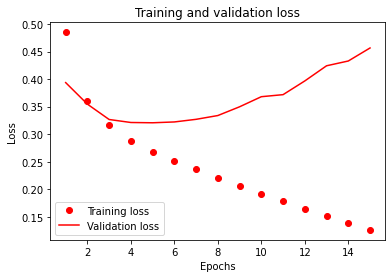

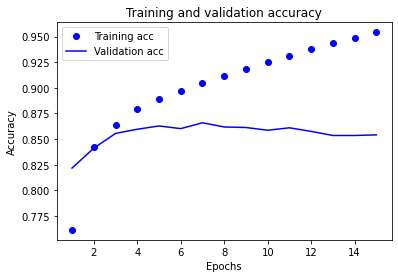

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict4['accuracy']
val_acc = history_dict4['val_accuracy']
loss = history_dict4['loss']
val_loss = history_dict4['val_loss']

epochs = range(1, len(acc) + 1)

# "ro"는 "빨간색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# r는 "빨간 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

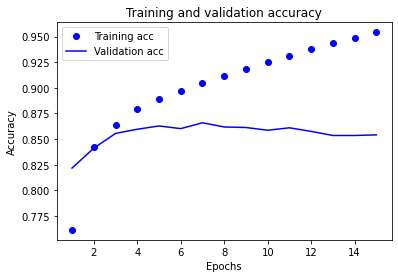

In [ ]:
plt.clf()   # 그림을 초기화합니다
# "bo"는 "파란색 점"입니다
plt.plot(epochs, acc, 'bo', label='Training acc')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# # 테스트셋을 통한 모델 평가
results4 = model4.evaluate(X_test, y_test, verbose=2)
print(results4)

# 학습 데이터의 정확도는 지속적으로 상승했으나 검증용 데이터의 학습률은 미세하게 낮아지고있다.
# loss 그래프에서 에포크 6에서부터 Validation loss가 증가하는 것을 볼 수 있다. 이 부분부터 모델이 과적합을 일으킨다.
# 앞서 3가지 모델보다 loss, accuracy측면에서 모두 개선된 부분을 볼 수 있다.
# accuracy가 0.85 이상을 넘었지만 다시 돌렸을때는 나오지않았다.
# 한국어 embedding이 실효성이 있다고 생각한다.

1537/1537 - 19s - loss: 0.4673 - accuracy: 0.8494 - 19s/epoch - 12ms/step
[0.46733707189559937, 0.8494415879249573]


In [ ]:
# 모델 구성 - 2 (Bi - LSTM)
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

model5 = tf.keras.Sequential()
model5.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model5.add(keras.layers.Bidirectional(LSTM(64)))
model5.add(keras.layers.Dense(1, activation='sigmoid'))

model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,084,609
Trainable params: 1,084,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습 진행하기

model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  
# 앞선 모델들이 낮은 에포크에서 이미 validation loss가 증가하는 현상을 보여 에포크를 10으로 낮춰서 학습해보기로 결정하였다.

history5 = model5.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 60s 210ms/step - loss: 0.4786 - accuracy: 0.7659 - val_loss: 0.3888 - val_accuracy: 0.8242
Epoch 2/10
266/266 [==============================] - 55s 207ms/step - loss: 0.3553 - accuracy: 0.8446 - val_loss: 0.3446 - val_accuracy: 0.8472
Epoch 3/10
266/266 [==============================] - 53s 200ms/step - loss: 0.3116 - accuracy: 0.8664 - val_loss: 0.3284 - val_accuracy: 0.8541
Epoch 4/10
266/266 [==============================] - 53s 200ms/step - loss: 0.2841 - accuracy: 0.8805 - val_loss: 0.3370 - val_accuracy: 0.8534
Epoch 5/10
266/266 [==============================] - 53s 199ms/step - loss: 0.2641 - accuracy: 0.8900 - val_loss: 0.3323 - val_accuracy: 0.8578
Epoch 6/10
266/266 [==============================] - 53s 199ms/step - loss: 0.2451 - accuracy: 0.8994 - val_loss: 0.3222 - val_accuracy: 0.8637
Epoch 7/10
266/266 [==============================] - 53s 198ms/step - loss: 0.2285 - accuracy: 0.9077 - val_loss: 0.3254 - val_ac

In [ ]:
history_dict5 = history5.history
print(history_dict5.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


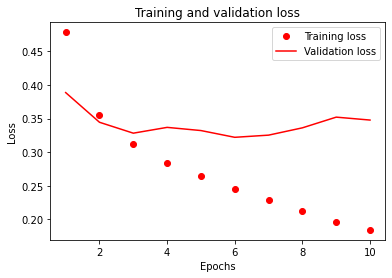

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict5['accuracy']
val_acc = history_dict5['val_accuracy']
loss = history_dict5['loss']
val_loss = history_dict5['val_loss']

epochs = range(1, len(acc) + 1)

# "ro"는 "빨간색 점"입니다
plt.plot(epochs, loss, 'ro', label='Training loss')
# r는 "빨간 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

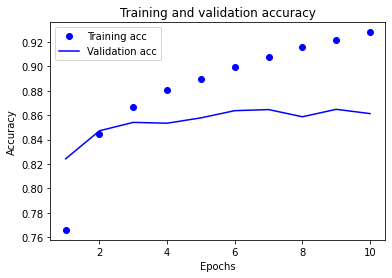

In [ ]:
plt.clf()   # 그림을 초기화합니다
# "bo"는 "파란색 점"입니다
plt.plot(epochs, acc, 'bo', label='Training acc')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
results5 = model5.evaluate(X_test, y_test, verbose=2)
print(results5)

# 학습 데이터는 꾸준하게 정확도가 상승하였고, 검증용 데이터의 정확도는 변동이 있으나 증가 추세이다. 더 많은 에포크를 돌려봐야 알 것 같다.
# 다른 모형의 학습 결과와 달리 하락하는 부분이 3번 존재하였다. 다른 모델들 보다 과적합 위험이 적은 것으로 보인다.
# 앞서 LSTM 모델보다 loss, accuracy측면에서 모두 개선된 부분을 볼 수 있다.
# accuracy가 0.85 이상나오게되었다.
# 한국어 embedding이 실효성이 있다고 생각한다.

1537/1537 - 25s - loss: 0.3658 - accuracy: 0.8565 - 25s/epoch - 16ms/step
[0.3658424913883209, 0.85645991563797]


# 회고

1. 이번 프로젝트에서 어려웠던 점
 
 (1) embedding에서 알 수 없는 key error가 지속적으로 발생하였습니다. 원인을 찾기위해 index_to_word를 출력하여 확인했습니다. key가 6번 시작하는 비정상적인 형태를 보였습니다. 이를 해결하기위해 load_data 함수를 보던 중 word_to_index를 구성하는 부분에서 빈 칸이 있음을 확인했고 LMS에서 입력했던 'PAD', 'BOS', 'UNK', 'UNUSED'을 입력하여 문제를 해결했습니다.

  (2) 한국어 Word2vec을 사용하여 좀 더 성능을 낼 수 있었지만 정확도 85%는 쉽지않았습니다.
 

2. 프로젝트를 진행하면서 알게된 부분 또는 아직 이해하지 못한 부분

(1) 원하는 버젼의 라이브러리를 영구적으로 설치할 수 없을까?

- 항상 aiffel의 LMS와 버젼을 최대한 맞추어 진행하려 하다보니 매번 라이브러리를 설치하고는 하였습니다. colab에 영구적으로 설치가 가능한 방법을 알게되어 이번 프로젝트에서 gensim은 재설치없이 사용할 수 있게 되었습니다.

- konlpy와 Mecab은 시도해봤으나 잘 되지않았고 향후 해결하기위해 노력해야겠습니다.

(2) LSTM말고 다른 모델도 활용해보자
- LMS에서 RNN을 양방향으로 사용하는 경우도 있다고하여 Bidirectional LSTM을 사용하여 분석에 사용해봤습니다.

(3) 모델의 과적합 기준
- 항상 이 부분을 구체적으로 이해하지못했지만 이번 기회에 다시 공부하여 그래프 해석에 의견을 달아보았습니다.




참조

(1) [RNN 양방향 적용](https://lms.aiffel.io/course/244/node/548/step/3905/readonly)

(2) [과적합, 과소적합](https://untitledtblog.tistory.com/158)

(3) [파이썬 텍스트 마이닝 완벽 가이드](http://www.kyobobook.co.kr/product/detailViewKor.laf?ejkGb=KOR&mallGb=KOR&barcode=9791158393007&orderClick=LEa&Kc=) (저자 : 박상언, 강주영, 정석찬 / 참고한 내용 : Bi-LSTM 이론 및 코드 / 참고한 페이지 : 233~234p)

(4) [colab 라이브러리 설치](https://teddylee777.github.io/colab/colab%EC%97%90%EC%84%9C-python%ED%8C%A8%ED%82%A4%EC%A7%80%EB%A5%BC-permanently-%EC%9D%B8%EC%8A%A4%ED%86%A8%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95)



